In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from SSVEP1 import SsvepLoading,TrialsBuilding,Classify
from estimation import Covariances, mean,scm
from pyriemann.estimation import Covariances as COV
import scipy


In [2]:
#1. Load data

data_path = 'ssvep_exo/'
subj_list,records = SsvepLoading(data_path)

In [3]:
records

{0: ['subject01_run1', 'subject01_run2'],
 1: ['subject02_run1', 'subject02_run2'],
 2: ['subject03_run1', 'subject03_run2'],
 3: ['subject04_run1', 'subject04_run2'],
 4: ['subject05_run1', 'subject05_run2'],
 5: ['subject06_run1', 'subject06_run2'],
 6: ['subject07_run1', 'subject07_run2', 'subject07_run3'],
 7: ['subject08_run1', 'subject08_run2'],
 8: ['subject09_run1', 'subject09_run2'],
 9: ['subject10_run1', 'subject10_run2', 'subject10_run3', 'subject10_run4'],
 10: ['subject11_run1', 'subject11_run2'],
 11: ['subject12_run1',
  'subject12_run2',
  'subject12_run3',
  'subject12_run4',
  'subject12_run5']}

In [5]:
def huber_prime(x,r):
    if x < r:
        return 1
    else:
        return 0


# Robustified MDM using scm

In [9]:
nb_classes = 4 #if you want to exclude "resting", set nb_classes to 3
method = "MDM"
freq_band = 1
tmax=5
tmin = 0.5
results_non_robust = { subj : None for subj in  range(len(subj_list))}
results_huber1 = { subj : None for subj in  range(len(subj_list))}
results_huber2 = { subj : None for subj in  range(len(subj_list))}
results_student1 = { subj : None for subj in  range(len(subj_list))}
results_student2 = { subj : None for subj in  range(len(subj_list))}
results_tyler = { subj : None for subj in  range(len(subj_list))}


for subject in range(len(subj_list)):
    
        print("--------------",subj_list[subject],"--------------")
    
        TrialsBuild = TrialsBuilding(data_path,records,subj_list,subject,nb_classes,tmin=tmin,tmax=tmax,freq_band=freq_band)
        extended_trials,labels =TrialsBuild.extended_trials_and_labels_all_sessions() 
        nb_trains = len(records[subject])-1
        
        COVS = Covariances(estimator="scm")
        COVS.fit(extended_trials,labels)
        covs = COVS.transform(extended_trials)
        
        classif_non_robust = Classify(method,covs,labels,nb_trains,nb_classes)
        train_acc_non_robust,test_acc_non_robust = classif_non_robust.accuracies()
        
        N,n,m = extended_trials.shape
        clean_prop = 0.9

        param1 = 0.5*scipy.stats.chi2.ppf(clean_prop,2*n)
        u_prime1 = lambda x : huber_prime(x,param1)
        
        classif_huber1 = Classify(method,covs,labels,nb_trains,nb_classes,u_prime=u_prime1)
        train_acc_huber1,test_acc_huber1 = classif_huber1.accuracies()
        
        params = []
        for k in range(N): # for the k^th trial
            X = extended_trials[k,:,:]-mean(extended_trials[k,:,:])
            all_arg = [X[:,i].T@np.linalg.pinv(covs[k,:,:])@X[:,i] for i in range(m)]
            indx = sorted(range(len(all_arg)), key=lambda k: all_arg[k])
            nb_clean_data = int(m*clean_prop)
            params.append(all_arg[indx[nb_clean_data]])
        u_prime2 = lambda x : [huber_prime(x,params[k]) for k in range(N)]
        classif_huber2 = Classify(method,covs,labels,nb_trains,nb_classes,u_prime=u_prime2)
        train_acc_huber2,test_acc_huber2 = classif_huber2.accuracies()
        
        ddl = 5
        u_prime3 = lambda x : 0.5*ddl*(n+0.5*ddl)/(0.5*ddl+x)**2
        classif_student1 = Classify(method,covs,labels,nb_trains,nb_classes,u_prime=u_prime3)
        train_acc_student1,test_acc_student1 = classif_student1.accuracies()
        
        u_prime4 = lambda x : (n+0.5*ddl)/(0.5*ddl+x)
        classif_student2 = Classify(method,covs,labels,nb_trains,nb_classes,u_prime=u_prime4)
        train_acc_student2,test_acc_student2 = classif_student2.accuracies()
        
        u_prime5 = lambda x : n/x
        classif_tyler = Classify(method,covs,labels,nb_trains,nb_classes,u_prime=u_prime5)
        train_acc_tyler,test_acc_tyler= classif_tyler.accuracies()
        
        print("Train :")
        print(" non robust=",train_acc_non_robust,"/ huber1=",train_acc_huber1,"/ huber2=",train_acc_huber2,
             "/ student1=",train_acc_student1,"/ student2=",train_acc_student2," /tyler=",train_acc_tyler)
        print("Test  : ")
        print(" non robust=",test_acc_non_robust,"/ huber1=",test_acc_huber1,"/ huber2=",test_acc_huber2,
              "/ student1=",test_acc_student1,"/ student2=",test_acc_student2," /tyler=",test_acc_tyler)
        
        results_non_robust[subject] = [ np.mean(train_acc_non_robust),np.mean(test_acc_non_robust)]
        results_huber1[subject] = [ np.mean(train_acc_huber1),np.mean(test_acc_huber1)]
        results_huber2[subject] = [ np.mean(train_acc_huber2),np.mean(test_acc_huber2)]
        results_student1[subject] = [ np.mean(train_acc_student1),np.mean(test_acc_student1)]
        results_student2[subject] = [ np.mean(train_acc_student2),np.mean(test_acc_student2)]
        results_tyler[subject] = [ np.mean(train_acc_tyler),np.mean(test_acc_tyler)]



-------------- subject01 --------------
Opening raw data file ssvep_exo/subject01/subject01_run1_raw.fif...
Isotrak not found
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.
Reading 0 ... 57023  =      0.000 ...   222.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject01/subject01_run2_raw.fif...
Isotrak not found
    Range : 0 ... 78143 =      0.000 ...   305.246 secs
Ready.
Reading 0 ... 78143  =      0.000 ...   305.246 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 non robust= [1. 1.] / huber1= [1. 1.] / huber2= [1. 1.] / student1= [0.875 1.   ] / student2= [1. 1.]  /tyler= [1. 1.]
Test  : 
 non robust= [0.6875  0.65625] / huber1= [0.6875  0.65625] / huber2= [0.6875  0.65625] / student1= [0.625 0.625] / student2= [0.65625 0.6875 ]  /tyler= [0.65625 0.6875 ]
-------------- subject02 --------------
Opening raw data file ssvep_exo/subject02/subject02_run1_raw.fif...
Isotrak not found
    Range : 0 ... 71711 =      0.000 ...   

Isotrak not found
    Range : 0 ... 110239 =      0.000 ...   430.621 secs
Ready.
Reading 0 ... 110239  =      0.000 ...   430.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject10/subject10_run2_raw.fif...
Isotrak not found
    Range : 0 ... 75583 =      0.000 ...   295.246 secs
Ready.
Reading 0 ... 75583  =      0.000 ...   295.246 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject10/subject10_run3_raw.fif...
Isotrak not found
    Range : 0 ... 78239 =      0.000 ...   305.621 secs
Ready.
Reading 0 ... 78239  =      0.000 ...   305.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject10/subject10_run4_raw.fif...
Isotrak not found
    Range : 0 ... 76895 =      0.000 ...   300.371 secs
Ready.
Reading 0 ... 76895  =      0.000 ...   300.371 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 non robust= [0.90625    0.95833333 0.89583333 0.89583333] / huber1= [0.90625    0.9583333

non robust - 0.7545138888888888
huber1 - 0.7349826388888888
huber2 - 0.7349826388888888
student1 - 0.7061197916666666
student2 - 0.75625
tyler - 0.7536458333333332


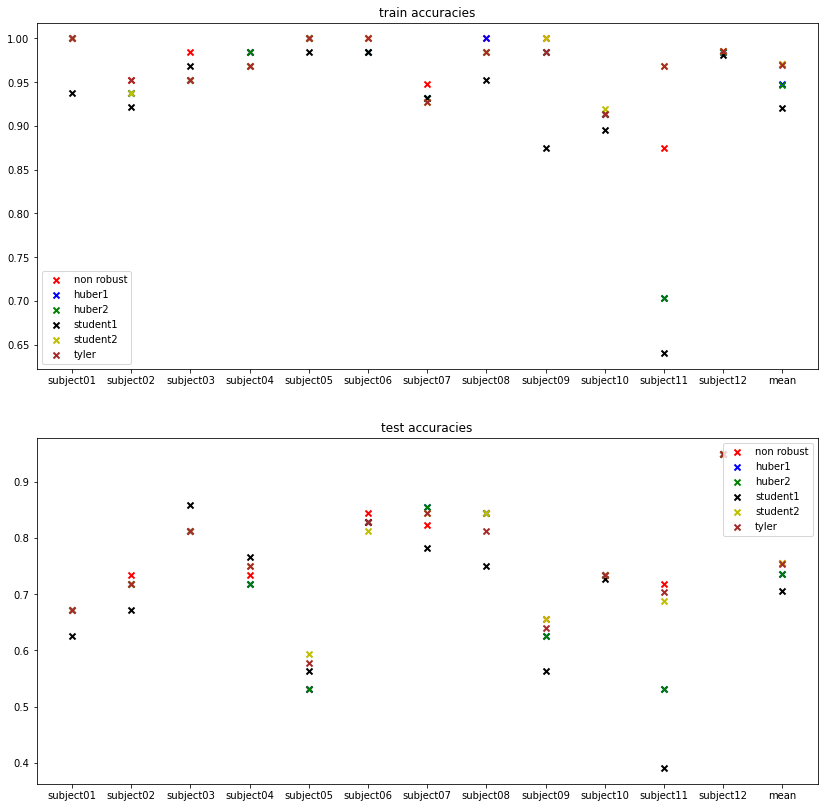

In [10]:
methods =["non robust","huber1","huber2","student1","student2","tyler"]
results = [results_non_robust,results_huber1,results_huber2,results_student1,results_student2,results_tyler]
colors = ['r','b','g','black','y','brown']

fig,axs = plt.subplots(2,1,figsize=(14,14))
axs = axs.flatten()
titles=["train accuracies","test accuracies"]
for i in range(len(axs)):
    for j in range(len(methods)):
        y = [results[j][subj][i] for subj in range(len(subj_list))]
        moy = np.mean(np.asarray(y))
        if i==1:
            print(methods[j],'-',moy)
        axs[i].scatter(subj_list+["mean"], y+[moy],label = methods[j],c = colors[j],marker="x",linewidth=2)
        axs[i].set_title(titles[i])
        axs[i].legend(loc="best")

## Double Robustification
### 1- Robust MDM using  no adaptive huber covariances

In [7]:
nb_classes = 4 #if you want to exclude "resting", set nb_classes to 3
method = "MDM"
freq_band = 1
tmax=5
tmin = 0.5
results_huber01 = { subj : None for subj in  range(len(subj_list))}
results_huber02 = { subj : None for subj in  range(len(subj_list))}
results_student01 = { subj : None for subj in  range(len(subj_list))}
results_tyler01 = { subj : None for subj in  range(len(subj_list))}

for subject in range(len(subj_list)):
    
        print("--------------",subj_list[subject],"--------------")
    
        TrialsBuild = TrialsBuilding(data_path,records,subj_list,subject,nb_classes,tmin=tmin,tmax=tmax,freq_band=freq_band)
        extended_trials,labels =TrialsBuild.extended_trials_and_labels_all_sessions() 
        nb_trains = len(records[subject])-1
        
        COVS0 = Covariances(estimator="scm")
        COVS0.fit(extended_trials,labels)
        covs0 = COVS0.transform(extended_trials)
        
        COVS1 = Covariances(estimator="huber non adaptive")
        COVS1.fit(extended_trials,labels)
        covs1 = COVS1.transform(extended_trials)
        
        
        N,n,m = extended_trials.shape
        clean_prop = 0.9

        param1 = 0.5*scipy.stats.chi2.ppf(clean_prop,2*n)
        u_prime1 = lambda x : huber_prime(x,param1)
        
        #covs = huber non adaptive + mdm robustified with huber non adaptive function
        classif_huber01 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime1)
        train_acc_huber01,test_acc_huber01 = classif_huber01.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with student function
        ddl = 5
        u_prime2 = lambda x : (n+0.5*ddl)/(0.5*ddl+x)
        classif_student01 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime2)
        train_acc_student01,test_acc_student01 = classif_student01.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with adaptive huber function
        params = []
        for k in range(N): # for the k^th trial
            X = extended_trials[k,:,:]-mean(extended_trials[k,:,:])
            all_arg = [X[:,i].T@np.linalg.pinv(covs0[k,:,:])@X[:,i] for i in range(m)]
            indx = sorted(range(len(all_arg)), key=lambda k: all_arg[k])
            nb_clean_data = int(m*clean_prop)
            params.append(all_arg[indx[nb_clean_data]])
        u_prime3 = lambda x : [huber_prime(x,params[k]) for k in range(N)]
        classif_huber02 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime3)
        train_acc_huber02,test_acc_huber02 = classif_huber02.accuracies()
        
        #covs = huber non adaptive + mdm robustified with non adaptive non normalized tyler function
        u_prime4 = lambda x : n/x
        classif_tyler01 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime4)
        train_acc_tyler01,test_acc_tyler01 = classif_tyler01.accuracies()
        
        print("Train :")
        print(" huber01=",train_acc_huber01,"/ huber02=",train_acc_huber02,
             "/ student01=",train_acc_student01,"/ tyler01=",train_acc_tyler01)
        
        print("Test :")
        print(" huber01=",test_acc_huber01,"/ huber02=",test_acc_huber02,
             "/ student01=",test_acc_student01,"/ tyler01=",test_acc_tyler01)
        
        results_huber01[subject] = [ np.mean(train_acc_huber01),np.mean(test_acc_huber01)]
        results_huber02[subject] = [ np.mean(train_acc_huber02),np.mean(test_acc_huber02)]
        results_student01[subject] = [ np.mean(train_acc_student01),np.mean(test_acc_student01)]
        results_tyler01[subject] = [ np.mean(train_acc_tyler01),np.mean(test_acc_tyler01)]


-------------- subject01 --------------
Opening raw data file ssvep_exo/subject01/subject01_run1_raw.fif...
Isotrak not found
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.
Reading 0 ... 57023  =      0.000 ...   222.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject01/subject01_run2_raw.fif...
Isotrak not found
    Range : 0 ... 78143 =      0.000 ...   305.246 secs
Ready.
Reading 0 ... 78143  =      0.000 ...   305.246 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [1. 1.] / huber02= [1. 1.] / student01= [1. 1.] / tyler01= [1. 1.]
Test :
 huber01= [0.6875  0.65625] / huber02= [0.6875  0.65625] / student01= [0.65625 0.6875 ] / tyler01= [0.65625 0.6875 ]
-------------- subject02 --------------
Opening raw data file ssvep_exo/subject02/subject02_run1_raw.fif...
Isotrak not found
    Range : 0 ... 71711 =      0.000 ...   280.121 secs
Ready.
Reading 0 ... 71711  =      0.000 ...   280.121 secs...
32 events found
Event 

Isotrak not found
    Range : 0 ... 75455 =      0.000 ...   294.746 secs
Ready.
Reading 0 ... 75455  =      0.000 ...   294.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject11/subject11_run2_raw.fif...
Isotrak not found
    Range : 0 ... 76415 =      0.000 ...   298.496 secs
Ready.
Reading 0 ... 76415  =      0.000 ...   298.496 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [0.5625 1.    ] / huber02= [0.5625 1.    ] / student01= [0.9375 1.    ] / tyler01= [0.9375 1.    ]
Test :
 huber01= [0.40625 0.8125 ] / huber02= [0.40625 0.8125 ] / student01= [0.65625 0.71875] / tyler01= [0.65625 0.71875]
-------------- subject12 --------------
Opening raw data file ssvep_exo/subject12/subject12_run1_raw.fif...
Isotrak not found
    Range : 0 ... 90527 =      0.000 ...   353.621 secs
Ready.
Reading 0 ... 90527  =      0.000 ...   353.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject12/subject12_run2_raw.

huber1 - 0.7467013888888888
huber2 - 0.7480034722222221
student - 0.7536458333333332
tyler - 0.7536458333333332


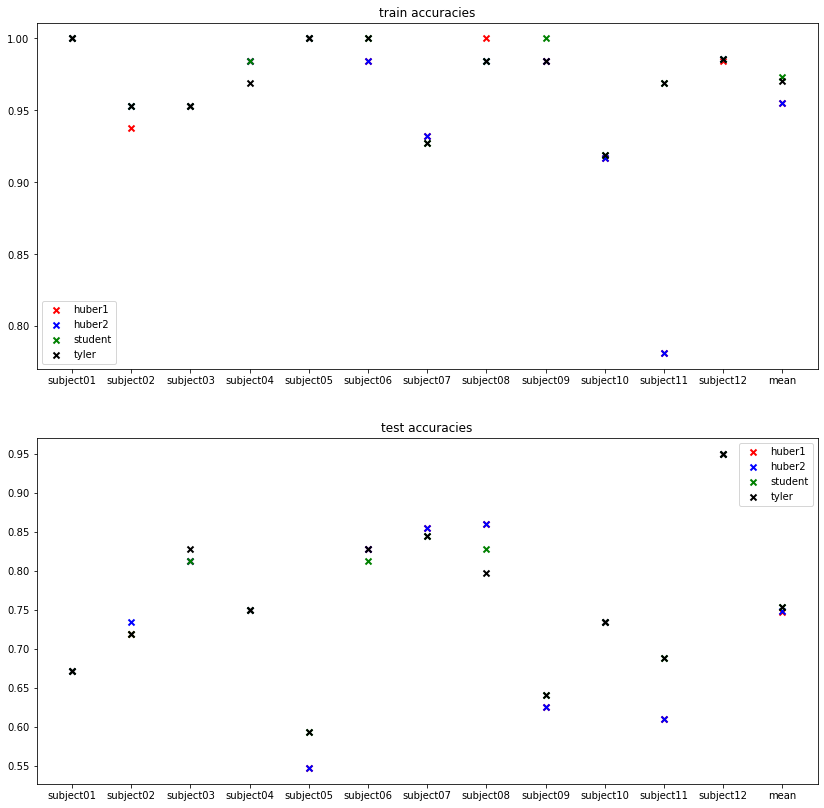

In [8]:
methods =["huber1","huber2","student","tyler"]
results = [results_huber01,results_huber02,results_student01,results_tyler01]
colors = ['r','b','g','black','y']

fig,axs = plt.subplots(2,1,figsize=(14,14))
axs = axs.flatten()
titles=["train accuracies","test accuracies"]
for i in range(len(axs)):
    for j in range(len(methods)):
        y = [results[j][subj][i] for subj in range(len(subj_list))]
        moy = np.mean(np.asarray(y))
        if i==1:
            print(methods[j],'-',moy)
        axs[i].scatter(subj_list+["mean"], y+[moy],label = methods[j],c = colors[j],marker="x",linewidth=2)
        axs[i].set_title(titles[i])
        axs[i].legend(loc="best")

### 2- Robust MDM using  adaptive huber covariances

In [14]:
nb_classes = 4 #if you want to exclude "resting", set nb_classes to 3
method = "MDM"
freq_band = 1
tmax=5
tmin = 0.5
results_huber11 = { subj : None for subj in  range(len(subj_list))}
results_huber12 = { subj : None for subj in  range(len(subj_list))}
results_student11 = { subj : None for subj in  range(len(subj_list))}
results_tyler11 = { subj : None for subj in  range(len(subj_list))}

for subject in range(len(subj_list)):
    
        print("--------------",subj_list[subject],"--------------")
    
        TrialsBuild = TrialsBuilding(data_path,records,subj_list,subject,nb_classes,tmin=tmin,tmax=tmax,freq_band=freq_band)
        extended_trials,labels =TrialsBuild.extended_trials_and_labels_all_sessions() 
        nb_trains = len(records[subject])-1
        
        COVS0 = Covariances(estimator="scm")
        COVS0.fit(extended_trials,labels)
        covs0 = COVS0.transform(extended_trials)
        
        COVS1 = Covariances(estimator="huber adaptive")
        COVS1.fit(extended_trials,labels)
        covs1 = COVS1.transform(extended_trials)
        
        
        N,n,m = extended_trials.shape
        clean_prop = 0.9

        param1 = 0.5*scipy.stats.chi2.ppf(clean_prop,2*n)
        u_prime1 = lambda x : huber_prime(x,param1)
        
        #covs = huber non adaptive + mdm robustified with huber non adaptive function
        classif_huber11 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime1)
        train_acc_huber11,test_acc_huber11 = classif_huber11.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with student function
        ddl = 5
        u_prime2 = lambda x : (n+0.5*ddl)/(0.5*ddl+x)
        classif_student11 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime2)
        train_acc_student11,test_acc_student11 = classif_student11.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with adaptive huber function
        params = []
        for k in range(N): # for the k^th trial
            X = extended_trials[k,:,:]-mean(extended_trials[k,:,:])
            all_arg = [X[:,i].T@np.linalg.pinv(covs0[k,:,:])@X[:,i] for i in range(m)]
            indx = sorted(range(len(all_arg)), key=lambda k: all_arg[k])
            nb_clean_data = int(m*clean_prop)
            params.append(all_arg[indx[nb_clean_data]])
        u_prime3 = lambda x : [huber_prime(x,params[k]) for k in range(N)]
        classif_huber12 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime3)
        train_acc_huber12,test_acc_huber12 = classif_huber12.accuracies()
        
        #covs = huber non adaptive + mdm robustified with non adaptive non normalized tyler function
        u_prime4 = lambda x : n/x
        classif_tyler11 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime4)
        train_acc_tyler11,test_acc_tyler11 = classif_tyler11.accuracies()
        
        print("Train :")
        print(" huber01=",train_acc_huber11,"/ huber02=",train_acc_huber12,
             "/ student01=",train_acc_student11,"/ tyler01=",train_acc_tyler11)
        
        print("Test :")
        print(" huber01=",test_acc_huber11,"/ huber02=",test_acc_huber12,
             "/ student01=",test_acc_student11,"/ tyler01=",test_acc_tyler11)
        
        results_huber11[subject] = [ np.mean(train_acc_huber11),np.mean(test_acc_huber11)]
        results_huber12[subject] = [ np.mean(train_acc_huber12),np.mean(test_acc_huber12)]
        results_student11[subject] = [ np.mean(train_acc_student11),np.mean(test_acc_student11)]
        results_tyler11[subject] = [ np.mean(train_acc_tyler11),np.mean(test_acc_tyler11)]


-------------- subject01 --------------
Opening raw data file ssvep_exo/subject01/subject01_run1_raw.fif...
Isotrak not found
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.
Reading 0 ... 57023  =      0.000 ...   222.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject01/subject01_run2_raw.fif...
Isotrak not found
    Range : 0 ... 78143 =      0.000 ...   305.246 secs
Ready.
Reading 0 ... 78143  =      0.000 ...   305.246 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [1. 1.] / huber02= [1. 1.] / student01= [1. 1.] / tyler01= [1. 1.]
Test :
 huber01= [0.6875  0.65625] / huber02= [0.6875  0.65625] / student01= [0.65625 0.6875 ] / tyler01= [0.65625 0.6875 ]
-------------- subject02 --------------
Opening raw data file ssvep_exo/subject02/subject02_run1_raw.fif...
Isotrak not found
    Range : 0 ... 71711 =      0.000 ...   280.121 secs
Ready.
Reading 0 ... 71711  =      0.000 ...   280.121 secs...
32 events found
Event 

Isotrak not found
    Range : 0 ... 75455 =      0.000 ...   294.746 secs
Ready.
Reading 0 ... 75455  =      0.000 ...   294.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject11/subject11_run2_raw.fif...
Isotrak not found
    Range : 0 ... 76415 =      0.000 ...   298.496 secs
Ready.
Reading 0 ... 76415  =      0.000 ...   298.496 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [0.5625 1.    ] / huber02= [0.5625 1.    ] / student01= [0.9375 1.    ] / tyler01= [0.9375 1.    ]
Test :
 huber01= [0.40625 0.8125 ] / huber02= [0.40625 0.8125 ] / student01= [0.65625 0.71875] / tyler01= [0.65625 0.71875]
-------------- subject12 --------------
Opening raw data file ssvep_exo/subject12/subject12_run1_raw.fif...
Isotrak not found
    Range : 0 ... 90527 =      0.000 ...   353.621 secs
Ready.
Reading 0 ... 90527  =      0.000 ...   353.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject12/subject12_run2_raw.

huber1 - 0.7440972222222221
huber2 - 0.7453993055555554
student - 0.75234375
tyler - 0.7536458333333332


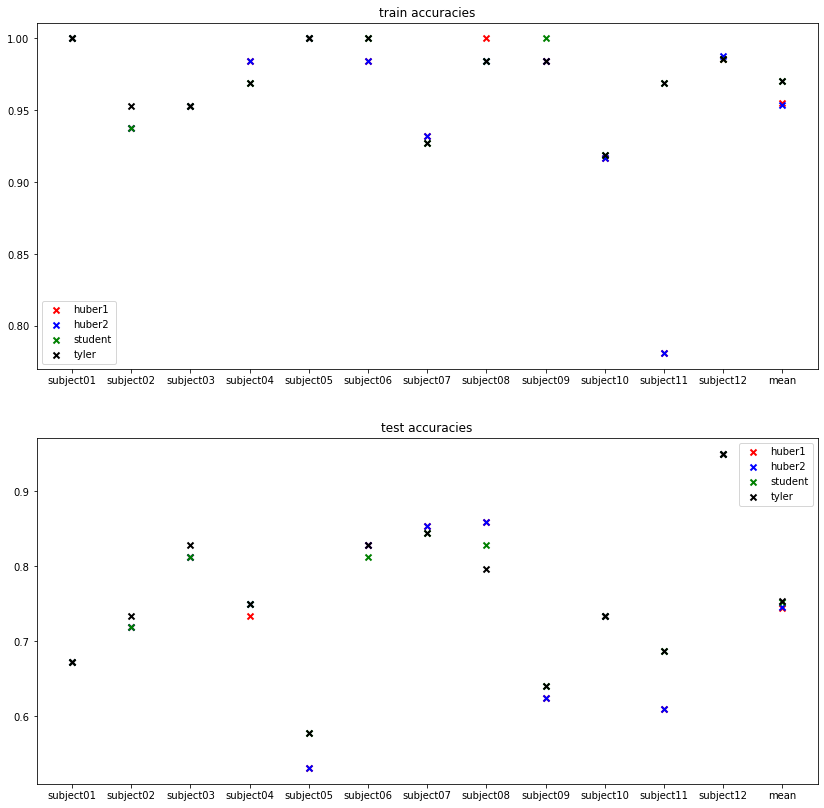

In [15]:
methods =["huber1","huber2","student","tyler"]
resultsbis = [results_huber11,results_huber12,results_student11,results_tyler11]
colors = ['r','b','g','black','y']

fig,axs = plt.subplots(2,1,figsize=(14,14))
axs = axs.flatten()
titles=["train accuracies","test accuracies"]
for i in range(len(axs)):
    for j in range(len(methods)):
        y = [resultsbis[j][subj][i] for subj in range(len(subj_list))]
        moy = np.mean(np.asarray(y))
        if i==1:
            print(methods[j],'-',moy)
        axs[i].scatter(subj_list+["mean"], y+[moy],label = methods[j],c = colors[j],marker="x",linewidth=2)
        axs[i].set_title(titles[i])
        axs[i].legend(loc="best")

### 3- Robust MDM using student covariances

In [13]:
nb_classes = 4 #if you want to exclude "resting", set nb_classes to 3
method = "MDM"
freq_band = 1
tmax=5
tmin = 0.5
results_huber21 = { subj : None for subj in  range(len(subj_list))}
results_huber22 = { subj : None for subj in  range(len(subj_list))}
results_student21 = { subj : None for subj in  range(len(subj_list))}
results_tyler21 = { subj : None for subj in  range(len(subj_list))}

for subject in range(len(subj_list)):
    
        print("--------------",subj_list[subject],"--------------")
    
        TrialsBuild = TrialsBuilding(data_path,records,subj_list,subject,nb_classes,tmin=tmin,tmax=tmax,freq_band=freq_band)
        extended_trials,labels =TrialsBuild.extended_trials_and_labels_all_sessions() 
        nb_trains = len(records[subject])-1
        
        COVS0 = Covariances(estimator="scm")
        COVS0.fit(extended_trials,labels)
        covs0 = COVS0.transform(extended_trials)
        
        COVS1 = Covariances(estimator="student")
        COVS1.fit(extended_trials,labels)
        covs1 = COVS1.transform(extended_trials)
        
        
        N,n,m = extended_trials.shape
        clean_prop = 0.9

        param1 = 0.5*scipy.stats.chi2.ppf(clean_prop,2*n)
        u_prime1 = lambda x : huber_prime(x,param1)
        
        #covs = huber non adaptive + mdm robustified with huber non adaptive function
        classif_huber21 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime1)
        train_acc_huber21,test_acc_huber21 = classif_huber21.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with student function
        ddl = 5
        u_prime2 = lambda x : (n+0.5*ddl)/(0.5*ddl+x)
        classif_student21 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime2)
        train_acc_student21,test_acc_student21 = classif_student21.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with adaptive huber function
        params = []
        for k in range(N): # for the k^th trial
            X = extended_trials[k,:,:]-mean(extended_trials[k,:,:])
            all_arg = [X[:,i].T@np.linalg.pinv(covs0[k,:,:])@X[:,i] for i in range(m)]
            indx = sorted(range(len(all_arg)), key=lambda k: all_arg[k])
            nb_clean_data = int(m*clean_prop)
            params.append(all_arg[indx[nb_clean_data]])
        u_prime3 = lambda x : [huber_prime(x,params[k]) for k in range(N)]
        classif_huber22 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime3)
        train_acc_huber22,test_acc_huber22 = classif_huber22.accuracies()
        
        #covs = huber non adaptive + mdm robustified with non adaptive non normalized tyler function
        u_prime4 = lambda x : n/x
        classif_tyler21 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime4)
        train_acc_tyler21,test_acc_tyler21 = classif_tyler21.accuracies()
        
        print("Train :")
        print(" huber01=",train_acc_huber21,"/ huber02=",train_acc_huber22,
             "/ student01=",train_acc_student21,"/ tyler01=",train_acc_tyler21)
        
        print("Test :")
        print(" huber01=",test_acc_huber21,"/ huber02=",test_acc_huber22,
             "/ student01=",test_acc_student21,"/ tyler01=",test_acc_tyler21)
        
        results_huber21[subject] = [ np.mean(train_acc_huber21),np.mean(test_acc_huber21)]
        results_huber22[subject] = [ np.mean(train_acc_huber22),np.mean(test_acc_huber22)]
        results_student21[subject] = [ np.mean(train_acc_student21),np.mean(test_acc_student21)]
        results_tyler21[subject] = [ np.mean(train_acc_tyler21),np.mean(test_acc_tyler21)]


-------------- subject01 --------------
Opening raw data file ssvep_exo/subject01/subject01_run1_raw.fif...
Isotrak not found
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.
Reading 0 ... 57023  =      0.000 ...   222.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject01/subject01_run2_raw.fif...
Isotrak not found
    Range : 0 ... 78143 =      0.000 ...   305.246 secs
Ready.
Reading 0 ... 78143  =      0.000 ...   305.246 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [1. 1.] / huber02= [1. 1.] / student01= [1. 1.] / tyler01= [1. 1.]
Test :
 huber01= [0.6875 0.625 ] / huber02= [0.6875 0.625 ] / student01= [0.65625 0.65625] / tyler01= [0.65625 0.65625]
-------------- subject02 --------------
Opening raw data file ssvep_exo/subject02/subject02_run1_raw.fif...
Isotrak not found
    Range : 0 ... 71711 =      0.000 ...   280.121 secs
Ready.
Reading 0 ... 71711  =      0.000 ...   280.121 secs...
32 events found
Event IDs:

Isotrak not found
    Range : 0 ... 75455 =      0.000 ...   294.746 secs
Ready.
Reading 0 ... 75455  =      0.000 ...   294.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject11/subject11_run2_raw.fif...
Isotrak not found
    Range : 0 ... 76415 =      0.000 ...   298.496 secs
Ready.
Reading 0 ... 76415  =      0.000 ...   298.496 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [0.5625 1.    ] / huber02= [0.5625 1.    ] / student01= [0.9375 1.    ] / tyler01= [0.9375 1.    ]
Test :
 huber01= [0.40625 0.8125 ] / huber02= [0.40625 0.8125 ] / student01= [0.6875  0.71875] / tyler01= [0.65625 0.71875]
-------------- subject12 --------------
Opening raw data file ssvep_exo/subject12/subject12_run1_raw.fif...
Isotrak not found
    Range : 0 ... 90527 =      0.000 ...   353.621 secs
Ready.
Reading 0 ... 90527  =      0.000 ...   353.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject12/subject12_run2_raw.

huber1 - 0.7478732638888889
huber2 - 0.7472222222222222
student - 0.7565538194444446
tyler - 0.7540798611111111


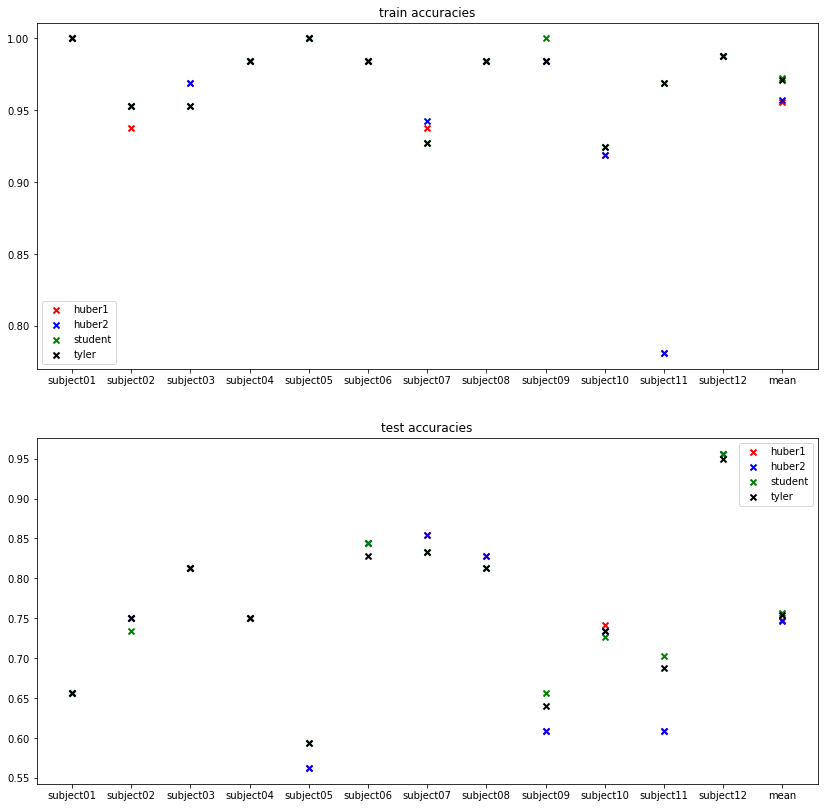

In [16]:
methods =["huber1","huber2","student","tyler"]
results2 = [results_huber21,results_huber22,results_student21,results_tyler21]
colors = ['r','b','g','black','y']

fig,axs = plt.subplots(2,1,figsize=(14,14))
axs = axs.flatten()
titles=["train accuracies","test accuracies"]
for i in range(len(axs)):
    for j in range(len(methods)):
        y = [results2[j][subj][i] for subj in range(len(subj_list))]
        moy = np.mean(np.asarray(y))
        if i==1:
            print(methods[j],'-',moy)
        axs[i].scatter(subj_list+["mean"], y+[moy],label = methods[j],c = colors[j],marker="x",linewidth=2)
        axs[i].set_title(titles[i])
        axs[i].legend(loc="best")

### 4- Robust MDM using adaptive Tyler covariances

In [17]:
nb_classes = 4 #if you want to exclude "resting", set nb_classes to 3
method = "MDM"
freq_band = 1
tmax=5
tmin = 0.5
results_huber31 = { subj : None for subj in  range(len(subj_list))}
results_huber32 = { subj : None for subj in  range(len(subj_list))}
results_student31 = { subj : None for subj in  range(len(subj_list))}
results_tyler31 = { subj : None for subj in  range(len(subj_list))}

for subject in range(len(subj_list)):
    
        print("--------------",subj_list[subject],"--------------")
    
        TrialsBuild = TrialsBuilding(data_path,records,subj_list,subject,nb_classes,tmin=tmin,tmax=tmax,freq_band=freq_band)
        extended_trials,labels =TrialsBuild.extended_trials_and_labels_all_sessions() 
        nb_trains = len(records[subject])-1
        
        COVS0 = Covariances(estimator="scm")
        COVS0.fit(extended_trials,labels)
        covs0 = COVS0.transform(extended_trials)
        
        COVS1 = Covariances(estimator="tyler adaptive")
        COVS1.fit(extended_trials,labels)
        covs1 = COVS1.transform(extended_trials)
        
        
        N,n,m = extended_trials.shape
        clean_prop = 0.9

        param1 = 0.5*scipy.stats.chi2.ppf(clean_prop,2*n)
        u_prime1 = lambda x : huber_prime(x,param1)
        
        #covs = huber non adaptive + mdm robustified with huber non adaptive function
        classif_huber31 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime1)
        train_acc_huber31,test_acc_huber31 = classif_huber31.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with student function
        ddl = 5
        u_prime2 = lambda x : (n+0.5*ddl)/(0.5*ddl+x)
        classif_student31 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime2)
        train_acc_student31,test_acc_student31 = classif_student31.accuracies()
        
        #covs = huber  non adaptive + mdm robustified with adaptive huber function
        params = []
        for k in range(N): # for the k^th trial
            X = extended_trials[k,:,:]-mean(extended_trials[k,:,:])
            all_arg = [X[:,i].T@np.linalg.pinv(covs0[k,:,:])@X[:,i] for i in range(m)]
            indx = sorted(range(len(all_arg)), key=lambda k: all_arg[k])
            nb_clean_data = int(m*clean_prop)
            params.append(all_arg[indx[nb_clean_data]])
        u_prime3 = lambda x : [huber_prime(x,params[k]) for k in range(N)]
        classif_huber32 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime3)
        train_acc_huber32,test_acc_huber32 = classif_huber32.accuracies()
        
        #covs = huber non adaptive + mdm robustified with non adaptive non normalized tyler function
        u_prime4 = lambda x : n/x
        classif_tyler31 = Classify(method,covs1,labels,nb_trains,nb_classes,u_prime=u_prime4)
        train_acc_tyler31,test_acc_tyler31 = classif_tyler31.accuracies()
        
        print("Train :")
        print(" huber01=",train_acc_huber31,"/ huber02=",train_acc_huber32,
             "/ student01=",train_acc_student31,"/ tyler01=",train_acc_tyler31)
        
        print("Test :")
        print(" huber01=",test_acc_huber31,"/ huber02=",test_acc_huber32,
             "/ student01=",test_acc_student31,"/ tyler01=",test_acc_tyler31)
        
        results_huber31[subject] = [ np.mean(train_acc_huber31),np.mean(test_acc_huber31)]
        results_huber32[subject] = [ np.mean(train_acc_huber32),np.mean(test_acc_huber32)]
        results_student31[subject] = [ np.mean(train_acc_student31),np.mean(test_acc_student31)]
        results_tyler31[subject] = [ np.mean(train_acc_tyler31),np.mean(test_acc_tyler31)]


-------------- subject01 --------------
Opening raw data file ssvep_exo/subject01/subject01_run1_raw.fif...
Isotrak not found
    Range : 0 ... 57023 =      0.000 ...   222.746 secs
Ready.
Reading 0 ... 57023  =      0.000 ...   222.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject01/subject01_run2_raw.fif...
Isotrak not found
    Range : 0 ... 78143 =      0.000 ...   305.246 secs
Ready.
Reading 0 ... 78143  =      0.000 ...   305.246 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [1. 1.] / huber02= [1. 1.] / student01= [1. 1.] / tyler01= [1. 1.]
Test :
 huber01= [0.6875 0.625 ] / huber02= [0.6875 0.625 ] / student01= [0.625   0.65625] / tyler01= [0.625   0.65625]
-------------- subject02 --------------
Opening raw data file ssvep_exo/subject02/subject02_run1_raw.fif...
Isotrak not found
    Range : 0 ... 71711 =      0.000 ...   280.121 secs
Ready.
Reading 0 ... 71711  =      0.000 ...   280.121 secs...
32 events found
Event IDs:

Isotrak not found
    Range : 0 ... 75455 =      0.000 ...   294.746 secs
Ready.
Reading 0 ... 75455  =      0.000 ...   294.746 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject11/subject11_run2_raw.fif...
Isotrak not found
    Range : 0 ... 76415 =      0.000 ...   298.496 secs
Ready.
Reading 0 ... 76415  =      0.000 ...   298.496 secs...
32 events found
Event IDs: [1 2 3 4]
Train :
 huber01= [0.5625 1.    ] / huber02= [0.5625 1.    ] / student01= [0.9375 1.    ] / tyler01= [0.9375 1.    ]
Test :
 huber01= [0.40625 0.8125 ] / huber02= [0.40625 0.8125 ] / student01= [0.6875  0.71875] / tyler01= [0.6875  0.71875]
-------------- subject12 --------------
Opening raw data file ssvep_exo/subject12/subject12_run1_raw.fif...
Isotrak not found
    Range : 0 ... 90527 =      0.000 ...   353.621 secs
Ready.
Reading 0 ... 90527  =      0.000 ...   353.621 secs...
32 events found
Event IDs: [1 2 3 4]
Opening raw data file ssvep_exo/subject12/subject12_run2_raw.

huber1 - 0.7460503472222221
huber2 - 0.7453993055555554
student - 0.7569010416666666
tyler - 0.7535590277777778


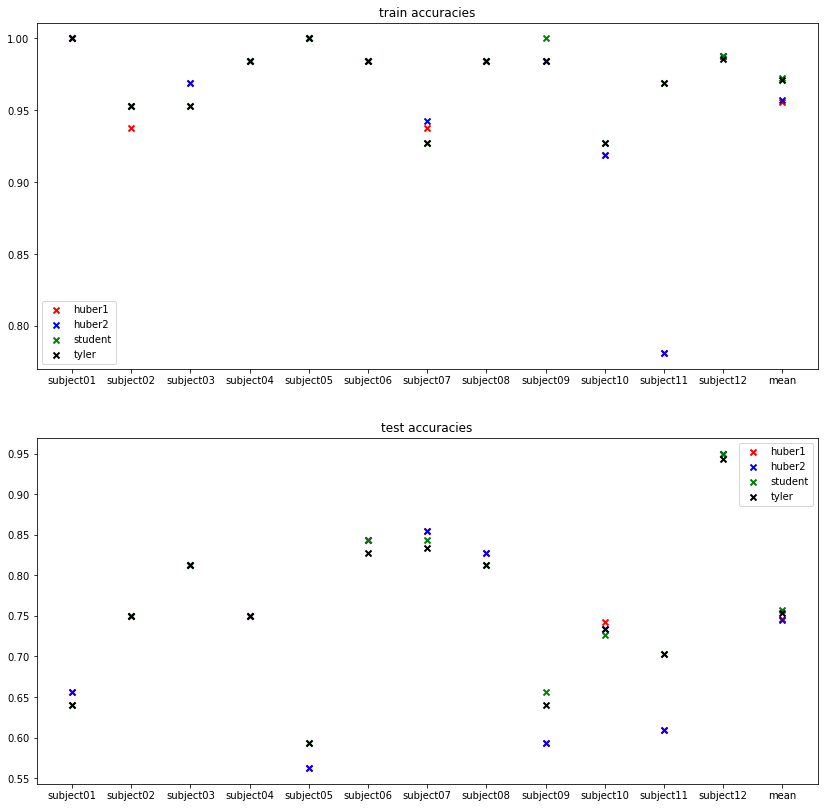

In [18]:
methods =["huber1","huber2","student","tyler"]
results3 = [results_huber31,results_huber32,results_student31,results_tyler31]
colors = ['r','b','g','black','y']

fig,axs = plt.subplots(2,1,figsize=(14,14))
axs = axs.flatten()
titles=["train accuracies","test accuracies"]
for i in range(len(axs)):
    for j in range(len(methods)):
        y = [results3[j][subj][i] for subj in range(len(subj_list))]
        moy = np.mean(np.asarray(y))
        if i==1:
            print(methods[j],'-',moy)
        axs[i].scatter(subj_list+["mean"], y+[moy],label = methods[j],c = colors[j],marker="x",linewidth=2)
        axs[i].set_title(titles[i])
        axs[i].legend(loc="best")